# Quality Control

## Motivation

Single-cell RNA-seq datasets have two important properties that one should have in mind when performing an analysis.
Firstly, scRNA-seq data is drop-out meaning that there is an excessive number of zeros in the data due to limiting mRNA.
Secondly, the potential for correcting the data and performing quality control might be limited as the data may be confounded with biology.
It is therefore crucial to select preprocessing methods that are suited to the underlying data without overcorrecting or removing biological effects.

The set of tools for the analysis of single-cell RNA-sequencing data is evolving fast due to new sequencing technologies and a growing number of captured cells, measured genes and identified cell populations {cite}`zappia_over_2021`.
Many of these tools are dedicated to preprocessing which aims to address the following analysis steps: doublet detection, quality control, normalization, feature selection, and dimensionality reduction.
The tools selected throughout this chapter can heavily affect downstream analysis and interpretation of the data.
For example, if you filter out too many cells during quality control, you might lose rare cell subpopulations and miss insight into interesting cell biology.
Whereas if you are too permissive, you might have a hard time annotating your cells if you did not exclude poor quality cells in your preprocessing pipeline.
Therefore, it is important to select tools that provide a best practice and that proved to outperform other tools with respect to downstream tasks.
In many cases, you will still have to re-assess your preprocessing analysis and change, for example, the filtering strategy.

The starting point of this notebook is single-cell data that has been processed as previously described in the raw processing chapter.
The data was aligned to obtain matrices of molecular counts, the so-called count matrices, or read counts (read matrices).
The difference between count and read matrices depends on whether unique molecular identifiers (UMIs) were included in the single-cell library construction protocol.
Read and count matrices have the dimension number of barcodes x number of transcripts.
It is important to note that the term "barcode" is used here instead of "cell" as a barcode might wrongly have tagged multiple cells (doublet) or might have not tagged any cell (empty droplet/well).
We will elaborate more on this in the section "Doublet detection".

## Dataset

We use a 10x Multiome data set generated for a single cell data integration challenge at the NeurIPS conference 2021 {cite}`luecken2021sandbox`. This dataset captures single-cell multiomics data from bone marrow mononuclear cells of 12 healthy human donors measured at four different sites to obtain nested batch effects. In this tutorial, we will use one batch of the aforementioned dataset, sample 4 of donor 8, to showcase the best practices for scRNA-seq data preprocessing.

Although single-cell count matrix preprocessing is generally a rather linear process where various quality control and preprocessing steps are conducted in a clear order, the introduction of specific steps here requires us to sometimes jump ahead to steps that we are going to introduce in one of the later subchapters. For example, we make use of clustering for the ambient RNA correction, but will only introduce clustering later.

As a first step, we first load the dataset with scanpy which is hosted on figshare.

In [1]:
import scanpy as sc

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

In [2]:
# switch to figshare afterwards
adata = sc.read_10x_h5("s4d8/filtered_feature_bc_matrix.h5")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


After reading the data, scanpy displays a warning that not all variable names are unique. This indicates that some variables (=genes) appear more than once which can lead to errors or unintended behavior for downstream analysis tasks. We execute the proposed function `var_names_make_unique()` which makes the variable name unique by appending a number string to each duplicate index element: ‘1’, ‘2’, etc. 

In [3]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

The dataset has the shape `n_obs` 16,934 x `n_vars` 36,601. This translates into `barcodes x number of transcripts`. We additionally inspect further information in `.var` in terms of gene_ids (Ensembl Id), feature_types and genome. 

## Correction of ambient RNA

For droplet based single cell RNA-seq experiments, a certain amount of background mRNAs is present in the dilution that gets distributed into the droplets with cells and sequenced along with them. The net effect of this is to produce a background contamination that represents expression not from the cell contained within a droplet, but the solution that contained the cells.

Droplet-based scRNA-seq generate counts of unique molecular identifiers (UMIs) for genes across multiple cells and aims to identify the number of molecules for each gene and each cell. It assumes that each droplet contains mRNA from single cells. Doublet, empty droplets and cell-free RNA can violate this assumption. Cell-free mRNA molecules represent background mRNA that is present in the dilution. These molecules get distributed along the droplets and are sequenced along with them. This contamination of cell-free mRNA in the input solution is typically called "the soup" which is created by cell lysis.

:::{figure-md} ambient RNA

<img src="../_static/images/ambient_rna.jpeg" alt="Ambient RNA Overview" class="bg-primary mb-1" width="800px">

In droplet-based sequencing technologies, droplets can incorporate ambient RNA or doublets (droplets with multiple cells captured). Contaminating ambient RNA is barcoded and counted together with the native mRNA from the cell leading to confounded counts. 

:::

Cell-free mRNA molecules, also known as ambient RNA, can confound the number of observed counts and can be seen as background contamination. It is important to correct droplet-based scRNA-seq datasets for cell-free mRNA as it may distort the interpretation of the data in our downstream analysis. Generally, the soup differs for each input solution and depends on the expression pattern across individual cells in the dataset. Methods for removal of ambient mRNA like SoupX {cite}`soupX/10.1093/gigascience/giaa151` and DecontX {cite}`decontX_yang_decontamination_2020` aim to estimate the composition of the soup and correct the count table with respect to the soup based expression.

As a first step, SoupX calculates the profile of the soup. It estimates the ambient mRNA expression profile from empty droplets as given by the unfiltered cellranger matrix. Next, SoupX estimates the cell specific contamination fraction. Lastly, it corrects the expression matrix according to the ambient mRNA expression profile and the estimated contamination.

The output of SoupX is a modified counts matrix, which can be used for any downstream analysis tool. 


We now load the required python and R packages needed for running SoupX. 

In [4]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [5]:
%%R
library(SoupX)

SoupX can be run without clustering information, however as Young and Behjati{cite}`soupX/10.1093/gigascience/giaa151` note that the results are better if a basic clustering is provided. SoupX can be used with the default clustering produced by cellranger or by manually defining clusters. We will showcase the latter in this notebook as the results from SoupX are not strongly sensitive to the clustering used. 

We now create a copy of our AnnData object, normalize it, reduce its dimensionality and compute default Leiden clusters on the processed copy. A subsequent chapter introduces clustering in more detail. For now we just need to know that Leiden clustering gives us partitions (communities) of cells in our dataset. We save the obtained clusters as `soupx_groups` and delete the copy of the AnnData object to save some memory in our notebook.  

Firstly, we generate a copy of our AnnData object, normalize and log1p transform it. We use simply proportional fitting (log1pPF normalization) at this point. More information on different normalization techniques can be found in the normalization chapter. 

In [6]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

Next, we compute the principle components of the data to obtain a lower dimentional representation. This representation is then used to generate a neighbourhood graph of the data and run leiden clustering on the KNN-graph. We add the clusters as `soupx_groups` to `.obs` and save them as a vector. 

In [7]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

We can now delete the copy of our AnnData object as we generated a vector of clusters which can be used in soupX.

In [8]:
del adata_pp

Next, we save the cell names, gene names and the data matirx of the filtered cellranger output. SoupX required a matrix of shape features x barcodes, so we have to transpose `.X`. 

In [9]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

SoupX additionally required the raw gene by cells matrix which is typically called `raw_feature_bc_matrix.h5` in the cellranger output. We load this similarly as before the `filtered_feature_bc_matrix.h5` with scanpy and run `.var_names_make_unique()` on the object and transpose the respective `.X`. 

In [10]:
adata_raw = sc.read_10x_h5("s4d8/raw_feature_bc_matrix.h5")
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
del adata_raw

We have now everything in place to run SoupX. The inputs are the filtered cellranger matrix of shape barcodes x cells, the raw table of droplets from cellranger of shape `barcodes x droplets`, the gene and cell names and the clusters obtained by simple leiden clustering. The output will be the corrected count matrix. 

We first construct a so called `SoupChannel` from the table of droplets and the table of cells. Next, we add metadata to the SoupChannel object which can be any metadata in the form of a `data.frame`. We add here 

In [12]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

SoupX successfully inferred corrected counts, which we can now store as an additional layer. In all following analysis steps, we would like to use the SoupX corrected count matrix, so we overwrite `.X` with the soupX corrected matrix. 

In [13]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

## Doublet Detection

Doublets are defined as two cells that are sequenced under the same cellular barcode, for example, if they were captured in the same droplet. That's why we used the term "barcode" instead if "cell" until now. A doublet is called homotypic if it is formed by the same cell type (but from different individuals) and heterotypic otherwise. Homotypic doublets are not necessarily identifiable from count matrices and are often considered innocuous as they can be identified with cell hashing or SNPs. Hence, their identification is not the main goal of the doublet detection methods. 

Doublets formed from different cell types or states are called heterotypic. Their identification is crucial as they are most likely misclassified and can lead to distorted downstream analysis steps. Hence, doublet detection and removal are typically initial preprocessing steps. Doublets can be either identified through their high number of reads and detected features, or with methods that create artificial doublets and compare these with the cells present in the dataset. Doublet detection methods are computationally efficient and there exist several software packages for this task. 

{cite}`xi_benchmarking_2021` benchmarked nine different doublet detection methods and assessed their performance with respect to computational efficiency and doublet detection accuracy. They additionally assessed scDblFinder in an addendum to their benchmark which achieved the highest doublet detection accuracy and a good computational efficiency and stability {cite}`xi_benchmarking_2021`.

In this tutorial, we will showcase the scDblFinder R package. scDblFinder randomly selects two droplets and creates artificial doublets from those by averaging their gene expression profiles. The doublet score is then defined as the fraction of artificial doublets in the k-nearest neighbor graph of each droplet in the principal component space.

:::{figure-md} Doublet detection

<img src="../_static/images/doublet_detection.jpeg" alt="Doublet detection overview" class="bg-primary mb-1" width="800px">

Doublets are droplets that contain more than one cell. Common doublet detection methods generate artificial doublets by randomly subsampling pairs of cells and averaging their gene expression profile to obtain doublet counts. These artificial doublets are projected together with the remaining calls into a lower dimensional principal component space. The doublet detection method computes a doublet score based on the number of artificial doublet neighbors in the k nearest neighbor graph.

:::

We first load some additional python and R packages.

In [14]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [15]:
data_mat = adata.X.T

We can now launch the doublet detection by using data_mat as input to scDblFinder within a SingleCellExperiment. scBblFinder adds several columns to the colData of sce. Three of them might be interesting for the analysis:

* `sce$scDblFinder.score`: the final doublet score (the higher the more likely that the cell is a doublet)

* `sce$scDblFinder.ratio` : the ratio of artificial doublets in the cell's neighborhood

* `sce$scDblFinder.class` : the classification (doublet or singlet)

We will only output the class argument and store it in the AnnData object in `.obs` . The other arguments can be added to the AnnData object similarly.

In [16]:
%%R -i data_mat -o droplet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
droplet_class = sce$scDblFinder.class

scDblFinder outputs a class with the classification `Singlet` and `Doublet`. We add this to our AnnData object in `.obs`.

In [17]:
adata.obs["scDblFinder_class"] = droplet_class
adata.obs.scDblFinder_class.value_counts()

singlet    13571
doublet     3363
Name: scDblFinder_class, dtype: int64

Finally, we remove all cells that were classified as doublets from the dataset.

In [18]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[adata.obs.scDblFinder_class == "singlet"].copy()

print(f"Number of cells after filtering of doublets: {adata.n_obs}")

Total number of cells: 16934
Number of cells after filtering of doublets: 13571



## Filtering low quality reads
The dataset might contain low-quality reads which are filtered by cell quality control (QC). Cell QC is typically performed on the following three QC covariates:

1. The number of counts per barcode (count depth)
2. The number of genes per barcode
3. The fraction of counts from mitochondrial genes per barcode

In cell QC these covariates are filtered via thresholding as they might correspond to dying cells. They might reflect cells with broken membranes whose cytoplasmic mRNA has leaked out and therefore only the mRNA in the mitochondria is still present. These cells might then show a low count depth, few detected genes and a high fraction of mitochondrial reads. It is, however, crucial to consider the three QC covariates jointly as otherwise it might lead to misinterpretation of cellular signal. Cells with a relatively high fraction of mitochondrial counts might for example be involved in respiratory processes and should not be filtered out. Whereas, cells with low or high counts might correspond to quiescent cell populations or cells larger in size. It is therefore preferred to consider multiple covariates when thresholding decisions on single covariates are made. In general, it is advised to exclude fewer cells and be as permissive as possible to avoid filtering out viable cell populations or small sub-populations.

QC on datasets is often performed in a manual fashion by looking at the distribution of different QC covariates. However, as datasets grow in size, it might be worth to consider automatic thresholding via MAD (median absolute deviations). Similar to {cite}`germain_pipecomp_2020`, to mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy. We want to highlight that it might be reasonable to re-assess the filtering after annotation of cells.

In QC, the first step is to calculate the QC covariates or metric. We compute these using the scanpy function `sc.pp.calculate_qc_metrics`, which can also calculate the proportions of counts for specific gene populations. We therefore define mitochondrial, ribosomal and hemoglobin genes. It is important to note that mitochondrial counts are annotated either with the prefix "mt-" or "MT-" depending on the species considered in the dataset. As mentioned, the dataset used in this notebook is human bone narrow, so mitochondrial counts are annotated with the prefix "MT-". For mouse datasets, the prefix is usually lower case, so "mt-".

In [19]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

We can now calculate the respective QC metrics with scanpy. This will add several new columns to `.var` and `.obs` as seen below. 

In [20]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

We now plot the three QC covariates `n_genes_by_counts`, `total_counts` and `ct_counts_Mt` per sample to assess how well the respective cells were captured. 

/Users/anna.schaar/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/Users/anna.schaar/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


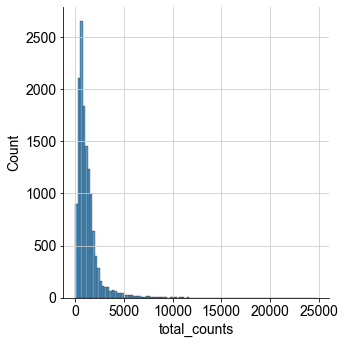

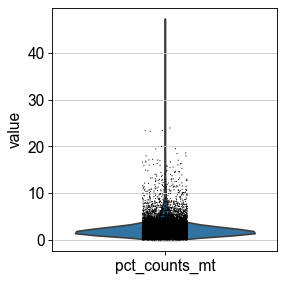

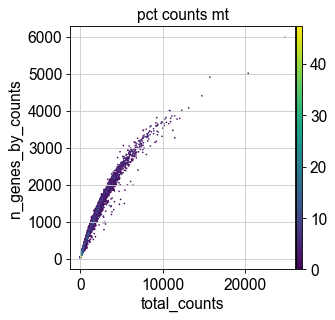

In [21]:
import seaborn as sns

p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

The plots indicate that some reads have a relatively high percentage of mitochondrial counts which are often associated with cell degradation. But since number of counts per cell is sufficiently high and percentage of mitochondrial reads is for most cells below 20 % we can still process the data. Based on these plots, one could now also define manual thresholds for filtering cells. Instead, we will show QC with automatic thresholding and filtering based on MAD.

First, we define a function that takes a `metric`, i.e. a column in `.obs` and the number of MADs (`nmad`) that is still permissive within the filtering strategy. 

In [22]:
import numpy as np


def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * M.mad()) | (
        np.median(M) + nmads * M.mad() < M
    )
    return outlier

We now apply this function to the `log1p_total_counts`, `log1p_n_genes_by_counts` and `pct_counts_in_top_20_genes` QC covariates each with a threshold of 5 MADs.

In [23]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    13194
True       377
Name: outlier, dtype: int64

`pct_counts_Mt` is filtered with 3 MADs. Additionally, cells with a percentage of mitochondrial counts exceeding 8 % are filtered out.

In [24]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

False    12920
True       651
Name: mt_outlier, dtype: int64

We now filter our AnnData object based on these two additional columns. 

In [25]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 13571
Number of cells after filtering of low quality cells: 12714


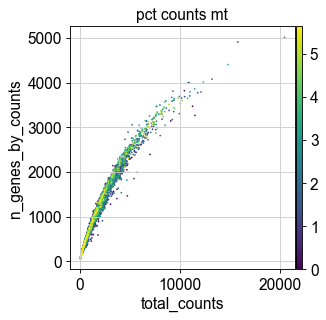

In [26]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

We additionally filter out genes that are not detected in at least 20 cells as these are not informative.

In [27]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 17882


We now removed ambient RNA, doublets and low quality cells from the dataset. During downstream clustering it might be useful to reassess quality control and the chosen parameters to potentially filter out more or less cells. 

In [28]:
adata.write("s4d8_subset_gex_qc.h5ad")

## Key Takeaways

1. Filtering of poor-quality cells should be based on median absolute deviations with lenient cutoffs to avoid bias against smaller subpopulations.
2. Feature-based filtering does not show benefits for downstream tasks. 
3. Doublets can be efficiently detected with tools like scDblFinder. 
4. Doublet detection methods should not be run on aggregated scRNA-seq data representing multiple batches. 

## References

```{bibliography}
:filter: docname in docnames
```